In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from tqdm import tqdm

In [11]:
import glob
import torch
from joblib import Parallel, delayed 

In [12]:

train = pd.read_csv('inputs/train.csv')

In [13]:
train['length_of_text'] = train['discourse_text'].apply(lambda x: len(x.split()))

In [5]:
def ner(df_texts, df_train):
    all_entities = []
    for _,  row in tqdm(df_texts.iterrows(), total=len(df_texts)):
        total = len(row['text_split'])
        entities = ['0'] * total

        for _, row2 in df_train[df_train['id'] == row['id']].iterrows():
            discourse = row2['discourse_type']
            list_ix = [int(x) for x in row2['predictionstring'].split(' ')]
            entities[list_ix[0]] = f'B-{discourse}'
            for k in list_ix[1:]: entities[k] = f'I-{discourse}'
        all_entities.append(entities)

    df_texts['entities'] = all_entities
    print('Completed mapping discourse to each token.')
    return df_texts

In [5]:
def agg_essays(train_flg):
    folder = 'train' if train_flg else 'test'
    names, texts =[], []
    for f in tqdm(glob.glob(f'inputs/{folder}/*.txt')):
        names.append(f.split('/')[-1].replace('.txt', ''))
        texts.append(open(f, 'r').read())
        

    df_texts = pd.DataFrame({'id': names, 'text': texts})
    df_texts['text_split'] = df_texts.text.str.split()
    print('Completed tokenizing texts.')
    return df_texts



In [14]:
df_texts = agg_essays("train")

100%|██████████| 15594/15594 [00:00<00:00, 37145.86it/s]


Completed tokenizing texts.


In [57]:
df_texts = ner(df_texts,train_corrected )

100%|██████████| 15594/15594 [05:12<00:00, 49.95it/s]


Completed mapping discourse to each token.


In [79]:
df_texts.head()

,id,text,text_split,entities
0,293C1D45E66B,"During the summer, students get do to do as th...","[During, the, summer,, students, get, do, to, ...","[B-Position, I-Position, I-Position, I-Positio..."
1,6DFF43AD5171,"Dear Principle,\n\nI think we should have cell...","[Dear, Principle,, I, think, we, should, have,...","[0, 0, B-Position, I-Position, I-Position, I-P..."
2,84D2A6C75C67,Talking to more than one person for ideas or a...,"[Talking, to, more, than, one, person, for, id...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea..."
3,838005D1D7DC,The Face on Mars is just a natural landform. M...,"[The, Face, on, Mars, is, just, a, natural, la...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea..."
4,F59DDBF5DB0B,Have you ever wondered why so many people in t...,"[Have, you, ever, wondered, why, so, many, peo...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea..."


In [8]:
def prepare_data_check(df_texts,train_corrected):
    
    ids = df_texts["id"].unique()

    ids_splits = np.array_split(ids, 4)
#     multiprocessing
    results = Parallel(n_jobs=4, backend="multiprocessing")(
        delayed(ner)(df_texts[df_texts.id.isin(idx)],train_corrected) for idx in ids_splits
    )
   
    df_results = pd.concat(results)
    
    return df_results 

In [8]:
import time 

In [97]:
start_time = time.time()
cc  = prepare_data_check(df_texts,train_corrected)
print(f'total time taken is {time.time()-start_time}')

 98%|█████████▊| 3839/3899 [01:38<00:01, 32.20it/s]

Completed mapping discourse to each token.

 99%|█████████▊| 3846/3898 [01:36<00:01, 40.88it/s]

100%|█████████▉| 3888/3899 [01:39<00:00, 29.90it/s]

Completed mapping discourse to each token.


 98%|█████████▊| 3812/3898 [01:36<00:02, 41.97it/s]

Completed mapping discourse to each token.


100%|██████████| 3898/3898 [01:38<00:00, 39.71it/s]


Completed mapping discourse to each token.
total time taken is 113.8557538986206


In [98]:
cc

,id,text,text_split,entities
0,293C1D45E66B,"During the summer, students get do to do as th...","[During, the, summer,, students, get, do, to, ...","[B-Position, I-Position, I-Position, I-Positio..."
1,6DFF43AD5171,"Dear Principle,\n\nI think we should have cell...","[Dear, Principle,, I, think, we, should, have,...","[0, 0, B-Position, I-Position, I-Position, I-P..."
2,84D2A6C75C67,Talking to more than one person for ideas or a...,"[Talking, to, more, than, one, person, for, id...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea..."
3,838005D1D7DC,The Face on Mars is just a natural landform. M...,"[The, Face, on, Mars, is, just, a, natural, la...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea..."
4,F59DDBF5DB0B,Have you ever wondered why so many people in t...,"[Have, you, ever, wondered, why, so, many, peo...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea..."
...,...,...,...,...
15589,44A73349B60A,"When looking for advice on a decision, do you ...","[When, looking, for, advice, on, a, decision,,...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea..."
15590,0C8E8861F91A,I agree with the claim against the value of us...,"[I, agree, with, the, claim, against, the, val...","[B-Position, I-Position, I-Position, I-Positio..."
15591,6E534D6E2282,Some people like to drive while otherss don't ...,"[Some, people, like, to, drive, while, otherss...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea..."
15592,A2A4548C52DA,"Phones have come a very long way since 1973, p...","[Phones, have, come, a, very, long, way, since...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea..."


In [9]:
import copy

In [125]:
def _prepare_data_helper_check(tokenizer, df,df_train,inference=False):
    samples = []
    all_entities = []
    for _, row in tqdm(df.iterrows(),total=len(df)):
          
        
        text = row['text']
        encoded_text = tokenizer.encode_plus(
            text.split(),
            is_split_into_words = True,
            padding = 'max_length',
            return_attention_mask = True,
            add_special_tokens=True,
            return_offsets_mapping=True,
            truncation = True,
            max_length = 2022
        )
        input_ids = encoded_text["input_ids"]
        input_labels = copy.deepcopy(input_ids)
        word_ids = encoded_text.word_ids()
        offset_mapping = encoded_text["offset_mapping"]
        attention_mask = encoded_text["attention_mask"]

        for k in range(len(input_labels)):
            input_labels[k] = "O"

        sample = {
            "id": row['id'],
            "input_ids": input_ids,
            "attention_mask":attention_mask,
            "text": text,
            "offset_mapping": offset_mapping,
            "word_ids" : word_ids
        }
        
        if inference:
            samples.append(sample)
            
        else:
            
            total = len(row['text_split'])
            entities = ['O'] * total

            for _, row2 in df_train[df_train['id'] == row['id']].iterrows():
                discourse = row2['discourse_type']
                list_ix = [int(x) for x in row2['predictionstring'].split(' ')]
                entities[list_ix[0]] = f'B-{discourse}'
                for k in list_ix[1:]: entities[k] = f'I-{discourse}'
#                 all_entities.append(entities)
                sample['input_labels'] = entities      
        samples.append(sample)
    
    return samples


In [15]:
def prepare_data(df,df_train, tokenizer,inference=False):
    samples = []
    ids = df["id"].unique()

    ids_splits = np.array_split(ids, 4)
#     multiprocessing
    results = Parallel(n_jobs=4, backend="multiprocessing")(
        delayed(_prepare_data_helper_check)(tokenizer, df[df.id.isin(idx)], df_train[df_train.id.isin(idx)],inference=inference) for idx in ids_splits
    )
    for result in results:
        samples.extend(result)

    return samples


In [127]:
start_time = time.time()
checking_new =  prepare_data(df_texts,train_corrected,tokenizer)
print(f'total time taken is {time.time()-start_time}')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 3898/3898 [00:48<00:00, 79.80it/s]


total time taken is 74.00049901008606


In [16]:
class DatasetRetriever_to_do(torch.utils.data.Dataset):
    def __init__(self, samples, max_len ,test=False, inference=False):
        super(DatasetRetriever_to_do, self).__init__()
        self.samples = samples
        self.max_len = max_len
        self.inference = inference
        self.test = test
        
        

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        input_ids = self.samples[item]["input_ids"]
        attention_mask = self.samples[item]["attention_mask"]
        word_ids = self.samples[item]["word_ids"]
        
        if self.inference:
            
            return {	
                    "ids": input_ids,	
                    "mask": attention_mask,	
                    "word_ids" :word_ids
                   } 
            
        else:
            input_labels = self.samples[item]["input_labels"]
            pad_labels = ['PAD' for i in range(self.max_len)]
            pad_labels[1:len(input_labels)] = input_labels[1:]
            pad_labels = [target_id_map[x] for x in pad_labels]
            
            
            return {
                    "ids": torch.tensor(input_ids, dtype=torch.long),
                    "mask": torch.tensor(attention_mask, dtype=torch.long),
                    "targets": torch.tensor(pad_labels, dtype=torch.long),
                    "word_ids" :torch.tensor(word_ids, dtype=torch.long)
                    }



In [156]:
cc.head()

,id,text,text_split,entities,length_of_text
0,293C1D45E66B,"During the summer, students get do to do as th...","[During, the, summer,, students, get, do, to, ...","[B-Position, I-Position, I-Position, I-Positio...",617
1,6DFF43AD5171,"Dear Principle,\n\nI think we should have cell...","[Dear, Principle,, I, think, we, should, have,...","[0, 0, B-Position, I-Position, I-Position, I-P...",328
2,84D2A6C75C67,Talking to more than one person for ideas or a...,"[Talking, to, more, than, one, person, for, id...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea...",461
3,838005D1D7DC,The Face on Mars is just a natural landform. M...,"[The, Face, on, Mars, is, just, a, natural, la...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea...",385
4,F59DDBF5DB0B,Have you ever wondered why so many people in t...,"[Have, you, ever, wondered, why, so, many, peo...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea...",334


In [79]:
data_check_laoder = DatasetRetriever_to_do(checking_new,tokenizer, 2022)

In [80]:
next(iter(data_check_laoder))

{'ids': tensor([   0, 1590,    5,  ...,    1,    1,    1]),
 'mask': tensor([1, 1, 1,  ..., 0, 0, 0]),
 'targets': tensor([  14,    2,    3,  ..., -100, -100, -100])}

In [192]:
class Datasetloader_check:
    def __init__(self, samples,max_len,test,inference,collate=None):
        self.samples = samples
        self.test = test
        self.inference= inference
        self.collate = collate
        self.max_len = max_len
        self.dataset = DatasetRetriever_to_do(samples=self.samples, max_len=self.max_len ,test=self.test, inference=self.inference)

    def fetch(self, batch_size, num_workers, drop_last=False, shuffle=True):
        if not self.test:
            sampler = torch.utils.data.RandomSampler(self.dataset)
        else:
            sampler = torch.utils.data.SequentialSampler(self.dataset)

        data_loader = torch.utils.data.DataLoader(
            self.dataset, batch_size=batch_size, sampler=sampler, shuffle=shuffle, num_workers=num_workers, pin_memory=True, drop_last=drop_last,collate_fn=self.collate)
        return data_loader

In [185]:
import dataset

In [193]:

cc_loader= Datasetloader_check(samples=checking_new[:4] ,max_len= 2022 ,test=False,inference=False).fetch(
    batch_size=2, num_workers=0, shuffle=False, drop_last=False)

In [194]:
new_cc = next(iter(cc_loader))

In [195]:
new_cc

{'ids': tensor([[    0,  1590,     5,  ...,     1,     1,     1],
         [    0, 12191, 44528,  ...,     1,     1,     1]]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'targets': tensor([[-100,    3,    3,  ..., -100, -100, -100],
         [-100,   14,    2,  ..., -100, -100, -100]])}

In [51]:
new_cc

{'ids': tensor([   0, 1590,    5,  ...,    1,    1,    1]),
 'mask': tensor([1, 1, 1,  ..., 0, 0, 0]),
 'targets': tensor([  14,    2,    3,  ..., -100, -100, -100])}

In [28]:
train['id'].nunique()

15594

In [15]:
train_folds = pd.read_csv('inputs/train_folds.csv')

In [13]:
train_corrected = pd.read_csv('inputs/train_corrected_kfold.csv')

In [16]:
train_folds.kfold.value_counts()

0    28997
2    28968
3    28904
1    28737
4    28687
Name: kfold, dtype: int64

In [106]:
fold_info = train_folds.groupby('id').agg({'kfold':'first'}).reset_index()

<AxesSubplot:ylabel='Frequency'>

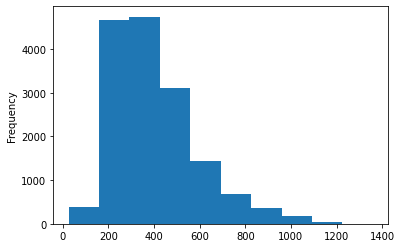

In [44]:
# number of words in a text file 
train.groupby('id')['length_of_text'].sum().reset_index()['length_of_text'].plot.hist()

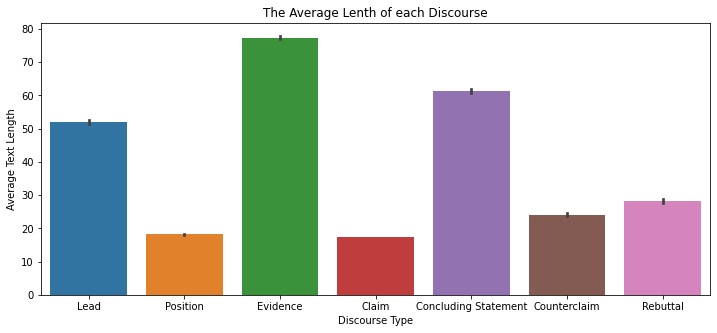

In [42]:

fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="discourse_type", y="length_of_text", data=train)
ax.set_title("The Average Lenth of each Discourse")
ax.set_xlabel("Discourse Type")
ax.set_ylabel("Average Text Length")
plt.show()

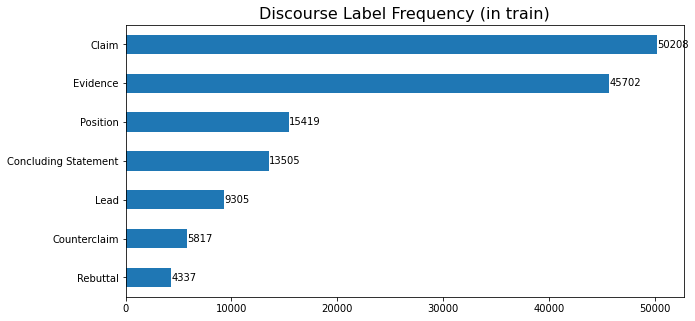

In [40]:
ax = (
    train["discourse_type"]
    .value_counts(ascending=True)
    .plot(kind="barh", figsize=(10, 5))
)
ax.set_title("Discourse Label Frequency (in train)", fontsize=16)
ax.bar_label(ax.containers[0], label_type="edge")
plt.show()

In [14]:
target_id_map = {
    "B-Lead": 0,
    "I-Lead": 1,
    "B-Position": 2,
    "I-Position": 3,
    "B-Evidence": 4,
    "I-Evidence": 5,
    "B-Claim": 6,
    "I-Claim": 7,
    "B-Concluding Statement": 8,
    "I-Concluding Statement": 9,
    "B-Counterclaim": 10,
    "I-Counterclaim": 11,
    "B-Rebuttal": 12,
    "I-Rebuttal": 13,
    "O": 14,
    "PAD": -100,
}


id_target_map = {v: k for k, v in target_id_map.items()}

In [15]:
id_target_map

{0: 'B-Lead',
 1: 'I-Lead',
 2: 'B-Position',
 3: 'I-Position',
 4: 'B-Evidence',
 5: 'I-Evidence',
 6: 'B-Claim',
 7: 'I-Claim',
 8: 'B-Concluding Statement',
 9: 'I-Concluding Statement',
 10: 'B-Counterclaim',
 11: 'I-Counterclaim',
 12: 'B-Rebuttal',
 13: 'I-Rebuttal',
 14: 'O',
 -100: 'PAD'}

In [7]:
len(target_id_map)

16

In [17]:
# import config
# import preprocessing
from transformers import AutoTokenizer

2022-02-07 22:18:56.581449: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [18]:
tokenizer = AutoTokenizer.from_pretrained("model_obj/longformer-base-4096/",add_prefix_space = True)

In [19]:
tokenizer

PreTrainedTokenizerFast(name_or_path='model_obj/longformer-base-4096/', vocab_size=50265, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})

In [12]:
sample = train[train.id.isin(['EDC567D40996' ,'6B4F7A0165B9'])] #"423A1CA112E2", 'A8445CABFECE', ,'4C471936CD75'

In [14]:
sample = train_folds[train_folds.kfold==0]  #"423A1CA112E2", 'A8445CABFECE', ,'4C471936CD75'

In [15]:
sample

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,kfold
10,A8445CABFECE,1.622576e+12,18.0,85.0,Drivers should not be able to use phones while...,Position,Position 1,3 4 5 6 7 8 9 10 11 12 13 14,0
11,A8445CABFECE,1.622576e+12,86.0,202.0,Drivers who used their phone while operating a...,Claim,Claim 1,15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 3...,0
12,A8445CABFECE,1.622576e+12,203.0,1030.0,According to an article by the Edgar Snyder Fi...,Evidence,Evidence 1,36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 5...,0
13,A8445CABFECE,1.622576e+12,1031.0,1243.0,"In conclusion, drivers should not able to work...",Concluding Statement,Concluding Statement 1,177 178 179 180 181 182 183 184 185 186 187 18...,0
71,A97DE0D49AEA,1.622645e+12,63.0,129.0,Driver's should desist from using their Cell ...,Position,Position 1,11 12 13 14 15 16 17 18 19 20,0
...,...,...,...,...,...,...,...,...,...
144235,0814426B27DF,1.617896e+12,1440.0,1563.0,that one of the people you asked for advice ma...,Claim,Claim 5,290 291 292 293 294 295 296 297 298 299 300 30...,0
144236,0814426B27DF,1.617896e+12,1564.0,1955.0,Some don't think all the same things if you we...,Evidence,Evidence 3,315 316 317 318 319 320 321 322 323 324 325 32...,0
144237,0814426B27DF,1.617896e+12,1956.0,2003.0,Some people will disagree with my three reasons,Counterclaim,Counterclaim 1,391 392 393 394 395 396 397 398,0
144238,0814426B27DF,1.617896e+12,2004.0,2075.0,but I don't like to listen to the people who d...,Rebuttal,Rebuttal 1,399 400 401 402 403 404 405 406 407 408 409 41...,0


In [16]:
train[train.id.isin(['408A7D3D2EEC', 'AFEC37C2D43F'])]

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,length_of_text
144261,408A7D3D2EEC,1.618325e+12,0.0,228.0,Imagine seeking advice from multiple people an...,Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,39
144262,408A7D3D2EEC,1.618325e+12,229.0,294.0,Seeking multiple opinions can help someone mak...,Position,Position 1,39 40 41 42 43 44 45 46 47 48,10
144263,408A7D3D2EEC,1.618325e+12,303.0,339.0,they can see which advice is better,Claim,Claim 1,50 51 52 53 54 55 56,7
144264,408A7D3D2EEC,1.618325e+12,340.0,356.0,more experienced,Claim,Claim 2,57 58,2
144265,408A7D3D2EEC,1.618325e+12,362.0,392.0,see the persons point of view.,Claim,Claim 3,60 61 62 63 64 65,6
144266,408A7D3D2EEC,1.618325e+12,470.0,779.0,Let's say this person needs to ask their teach...,Evidence,Evidence 1,79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 9...,57
144267,408A7D3D2EEC,1.618325e+12,876.0,1267.0,"For instance, they need help picking a collag...",Evidence,Evidence 2,152 153 154 155 156 157 158 159 160 161 162 16...,67
144268,408A7D3D2EEC,1.618325e+12,1356.0,1679.0,"For example, they can see what other people ha...",Evidence,Evidence 3,234 235 236 237 238 239 240 241 242 243 244 24...,61
144269,408A7D3D2EEC,1.618325e+12,1680.0,2052.0,"In conclusion, asking advice can help someone ...",Concluding Statement,Concluding Statement 1,295 296 297 298 299 300 301 302 303 304 305 30...,65
144270,AFEC37C2D43F,1.617803e+12,0.0,317.0,There has been at least one point in everyone'...,Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,61


In [18]:
# import os
# os.environ['TOKENIZERS_PARALLELISM']= "True"

In [16]:
check_samples= preprocessing.prepare_data(sample, tokenizer)

100%|██████████| 389/389 [00:03<00:00, 99.20it/s] 


In [17]:
check_samples_valid = preprocessing.prepare_data(train[train.id.isin(['408A7D3D2EEC', 'AFEC37C2D43F'])], tokenizer)

100%|██████████| 1/1 [00:00<00:00, 54.41it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [15]:
for k,_ in check_samples[0].items(): print(k)

id
input_ids
text
offset_mapping
input_labels


In [19]:
check_samples_valid[0]['id']

'408A7D3D2EEC'

In [26]:
len(check_samples[0]['input_ids']) , len(check_samples[0]['text']) , len(check_samples[0]['offset_mapping'])

(444, 2030, 444)

In [25]:
len(check_samples_valid[0]['input_ids']) , len(check_samples_valid[0]['text']) , len(check_samples_valid[0]['offset_mapping'])

(420, 2052, 420)

In [21]:
check_samples_valid[0]['text']

"Imagine seeking advice from multiple people and choosing the best decision that suits you. How does that make you feel? Asking for advice can be defined as someone who asks help from multiple people and makes the right decision. Seeking multiple opinions can help someone make a better decision because they can see which advice is better, more experienced, and see the persons point of view.\n\nAsking advice from multiple people can help you\xa0see\xa0which advice is better. Let's say this person needs to ask their teacher what book to choose. But, they also asked their friends the same question. They can now see which decision is better for them. It also depends if the advice is decent or not because if the advice is horrible, then that decision you make can affect the outcome.\n\nAnother way asking advice from multiple people can help you is they might have more experience. For instance, they need help picking a collage that suits their interest. When they ask their parents for advice

In [50]:
check_samples_valid[1]['text']

'There has been at least one point in everyone\'s life where you have asked or been asked for advice on a certain topic or subject. Everyone needs help with something, and it is a genetic trait to ask someone else for advice. However, a lot of people can be dishonest, and in this day and age, that number only goes up. Because of this, sometimes, asking just one person is not enough. Now a days, a person looking for help will most likely confront multiple people for advice to prevent problems with misinformation. The problem, while gigantic in scale now, can be rooted down to three different source problems I call "The Three Probl-Ms of Advice-giving". These three problems are: mistake, misunderstanding, and misdeed.\n\nWhile mistakes and misunderstanding might have similar definitions, in this context they are two completely different things. First of all, mistakes are when the advice-giver confuses two similar things and gives the wrong advice. A good example of this is when you are t

In [18]:
print(check_samples[0]['input_labels'])

['O', 'O', 'O', 'B-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'B-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'B-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'O', 'O', 'B-Evidence', 'I-Evide

In [13]:
import dataset

In [14]:
collate = preprocessing.Collate(tokenizer=tokenizer)


In [20]:
# Data loaders


valid_dataloader = dataset.Datasetloader(samples=check_samples_valid,tokenizer=tokenizer ,max_len= 2036 ,test=False,inference=False).fetch(
    batch_size=4, num_workers=config.NUM_WORKERS, shuffle=False, drop_last=False)

In [21]:
train_dataloader = dataset.Datasetloader(samples=check_samples,tokenizer=tokenizer ,max_len= 2036 ,test=False,inference=False).fetch(
    batch_size=2, num_workers=config.NUM_WORKERS, shuffle=False, drop_last=False)

In [22]:
next(iter(valid_dataloader))

{'ids': tensor([[    0,   970,    34,  ...,     1,     1,     1],
         [    0, 31206,  1818,  ...,     1,     1,     1]]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'targets': tensor([[  14,    0,    1,  ..., -100, -100, -100],
         [  14,    0,    1,  ..., -100, -100, -100]])}

In [23]:
next(iter(train_dataloader))

{'ids': tensor([[    0, 23314,   331,  ...,     1,     1,     1],
         [    0,  2895,   521,  ...,     1,     1,     1]]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'targets': tensor([[  14,   14,   14,  ..., -100, -100, -100],
         [  14,    0,    1,  ..., -100, -100, -100]])}

In [22]:
cc = next(iter(valid_dataloader))
cc1 = next(iter(train_dataloader))

In [23]:
len(cc['mask'][0]) , len(cc['ids'][0])

(665, 665)

In [24]:
len(cc1['mask'][0])

2036

In [9]:
def active_logits(raw_logits, word_ids):
    word_ids = word_ids.view(-1)
    active_mask = word_ids.unsqueeze(1).expand(word_ids.shape[0], Config.num_labels)
    active_mask = active_mask != NON_LABEL
    active_logits = raw_logits.view(-1, Config.num_labels)
    active_logits = torch.masked_select(active_logits, active_mask) # return 1dTensor
    active_logits = active_logits.view(-1, Config.num_labels) 
    return active_logits

def active_labels(labels):
    active_mask = labels.view(-1) != IGNORE_INDEX
    active_labels = torch.masked_select(labels.view(-1), active_mask)
    return active_labels

def active_preds_prob(active_logits):
    active_preds = torch.argmax(active_logits, axis = 1)
    active_preds_prob, _ = torch.max(active_logits, axis = 1)
    return active_preds, active_preds_prob

In [15]:
import torch
import math
import dataset
from transformers import AutoConfig

In [16]:
## Check the training and early stopping function
import engine
from model import LongformerModel


In [15]:
 # Intialize Model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_config = AutoConfig.from_pretrained(config.CONFIG_NAME)
model = LongformerModel(config.MODEL_PATH, config=model_config)



# optimizer
optimizer = engine.get_optimizer(model, type="i")


# mixed precision training with NVIDIA Apex
if config.FP16:
    model, optimizer = amp.initialize(model, optimizer, opt_level=config.FP16_OPT_LEVEL)


model.to(device)

# # scheduler
# num_training_steps = math.ceil(
#     len(train_dataloader) / config.GRADIENT_ACC_STEPS) * config.EPOCHS
# if config.WARMUP_RATIO > 0:
#     num_warmup_steps = int(config.WARMUP_RATIO * num_training_steps)
# else:
#     num_warmup_steps = 0
# print(
#     f"Total Training Steps: {num_training_steps}, Total Warmup Steps: {num_warmup_steps}")

# scheduler = engine.get_scheduler(
#     optimizer, num_warmup_steps, num_training_steps)


Some weights of the model checkpoint at model_obj/longformer-base-4096/ were not used when initializing LongformerModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


LongformerModel(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0): LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_global): Linear(i

In [30]:
for epoch in range(5):
    train_loss = engine.train_fn(
        train_dataloader, model, optimizer, device, scheduler)

    test_loss, predictions ,true_vals, metrics = engine.evaluate(
        valid_dataloader, model, device)
    
#     _, predictions ,_, _ = engine.evaluate(
#         valid_dataloader, model, device,inference=True)

    valid_features_ =   copy.deepcopy(check_samples_valid)
    df_pred, valid_features_ = get_preds_per_epoch(predictions,valid_features_)
    
    


    print(f"EPOCH : {epoch + 1}/{config.EPOCHS}")
    print(f"| Train Loss = {train_loss} | Valid Loss = {test_loss} | F1 Score  :{metrics} ")
    f1_score_avg = gen_validation_report(submission,valid_features_)
    print(f"Overall Validation avg F1: {f1_score_avg:.4f} ")

100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


EPOCH : 1/10
| Train Loss = 1.0519027082870405 | Valid Loss = 0.7603307962417603 | F1 Score  :{'f1': 0.386818356891241} 


100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


EPOCH : 2/10
| Train Loss = 0.6771706224586337 | Valid Loss = 0.7649502754211426 | F1 Score  :{'f1': 0.49478702061841406} 


 57%|█████▊    | 897/1560 [07:36<05:37,  1.97it/s]


KeyboardInterrupt: 

In [33]:
torch.save(model.state_dict(), 'output/longformers/model.bin')

In [16]:
## load model



model.load_state_dict(torch.load('output/longformers/model.bin', map_location=device))

model.to(device)

LongformerModel(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0): LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_global): Linear(i

In [17]:
train_set, valid_set_ = train_folds[train_folds['kfold']!= 0], train_folds[train_folds['kfold'] == 3]

In [25]:
valid_set = preprocessing.prepare_data(valid_set_, tokenizer)

In [22]:
train_folds[train_folds.id =="0000D23A521A"]

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,kfold
59951,0000D23A521A,1.617735e+12,0.0,170.0,"Some people belive that the so called ""face"" o...",Position,Position 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,3
59952,0000D23A521A,1.617735e+12,170.0,357.0,"It was not created by aliens, and there is no ...",Evidence,Evidence 1,34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 4...,3
59953,0000D23A521A,1.617735e+12,358.0,438.0,"A mesa is a naturally occuring rock formation,...",Evidence,Evidence 2,69 70 71 72 73 74 75 76 77 78 79 80 81 82 83,3
59954,0000D23A521A,1.617735e+12,438.0,626.0,"This ""face"" on mars only looks like a face bec...",Claim,Claim 1,84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 9...,3
59955,0000D23A521A,1.617735e+12,627.0,722.0,Many conspiracy theorists believe that NASA is...,Counterclaim,Counterclaim 1,117 118 119 120 121 122 123 124 125 126 127 12...,3
59956,0000D23A521A,1.617735e+12,722.0,836.0,These people would be very wrong. If NASA foun...,Rebuttal,Rebuttal 1,134 135 136 137 138 139 140 141 142 143 144 14...,3
59957,0000D23A521A,1.617735e+12,836.0,1014.0,"NASA's budget would increase drasticly, which ...",Evidence,Evidence 3,154 155 156 157 158 159 160 161 162 163 164 16...,3
59958,0000D23A521A,1.617735e+12,1015.0,1343.0,"So, NASA is not hiding life on Mars from us, a...",Concluding Statement,Concluding Statement 1,186 187 188 189 190 191 192 193 194 195 196 19...,3


In [23]:
train_folds[train_folds.id =="0000D23A521A"]['discourse_text'].values

array(['Some people belive that the so called "face" on mars was created by life on mars. This is not the case. The face on Mars is a naturally occuring land form called a mesa. ',
       'It was not created by aliens, and there is no consiracy to hide alien lifeforms on mars. There is no evidence that NASA has found that even suggests that this face was created by aliens. ',
       'A mesa is a naturally occuring rock formation, that is found on Mars and Earth. ',
       'This "face" on mars only looks like a face because humans tend to see faces wherever we look, humans are obviously extremely social, which is why our brain is designed to recognize faces. ',
       'Many conspiracy theorists believe that NASA is hiding life on Mars from the rest of the world. ',
       "These people would be very wrong. If NASA found life on Mars, then they would get millions of people's attention. ",
       "NASA's budget would increase drasticly, which means that their workers would get paid more. 

In [11]:
''.join(train_folds[train_folds.id =="0000D23A521A"]['discourse_text'].values)

'Some people belive that the so called "face" on mars was created by life on mars. This is not the case. The face on Mars is a naturally occuring land form called a mesa. It was not created by aliens, and there is no consiracy to hide alien lifeforms on mars. There is no evidence that NASA has found that even suggests that this face was created by aliens. A mesa is a naturally occuring rock formation, that is found on Mars and Earth. This "face" on mars only looks like a face because humans tend to see faces wherever we look, humans are obviously extremely social, which is why our brain is designed to recognize faces. Many conspiracy theorists believe that NASA is hiding life on Mars from the rest of the world. These people would be very wrong. If NASA found life on Mars, then they would get millions of people\'s attention. NASA\'s budget would increase drasticly, which means that their workers would get paid more. There is no good reason that NASA would hide life on Mars from the rest

In [22]:
encoded_text = tokenizer.encode_plus(
            text,
            add_special_tokens=False,
            return_offsets_mapping=True,
        )

In [20]:
valid_dataloader = dataset.Datasetloader(samples=valid_set,tokenizer=tokenizer ,max_len= config.MAX_SEQ_LEN  , test=False,inference=False).fetch(
        batch_size=2, num_workers=config.NUM_WORKERS, shuffle=False, drop_last=False)
    

In [21]:
import torch.nn as nn
import copy

In [22]:
model = nn.DataParallel(model)
model.load_state_dict(torch.load('output/longformers/checkpoint-fold-0/pytorch_model.bin', map_location=device))

model.to(device)

DataParallel(
  (module): LongformerModel(
    (longformer): LongformerModel(
      (embeddings): LongformerEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(4098, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): LongformerEncoder(
        (layer): ModuleList(
          (0): LongformerLayer(
            (attention): LongformerAttention(
              (self): LongformerSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (query_global): Linear(in_features=768, out_features=768, bias=True)
                (key_global): Linear(in_features=768, out_f

In [23]:
test_loss, predictions ,true_vals, metrics = engine.evaluate_testing(valid_dataloader, model, device)

  0%|          | 0/1559 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:65: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 1559/1559 [02:39<00:00,  9.75it/s]


In [28]:
len(predictions)

1559

In [29]:
len(valid_dataloader)

1559

In [44]:
valid_features_ =   copy.deepcopy(valid_set)
df_pred, valid_features_ = get_preds_per_epoch(predictions,valid_features_)

In [52]:
df_pred = link_evidence(df_pred)

In [53]:
df_pred

,id,class,predictionstring
0,A8445CABFECE,Evidence,89 90 91 92 93 94 95 96 97 98 99 100 101 102 1...
1,A8445CABFECE,Evidence,168 169 170 171 172 173 174 175 176 177 178 17...
2,A97DE0D49AEA,Evidence,181 182 183 184 185 186 187 188 189 190 191 19...
3,A97DE0D49AEA,Evidence,261 262 263 264 265 266 267 268 269 270 271 27...
4,AC594194F01C,Evidence,31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 4...
...,...,...,...
23856,0814426B27DF,Claim,52 53 54
23857,0814426B27DF,Claim,55 56 57
23858,0814426B27DF,Claim,58 59 60 61
23859,0814426B27DF,Claim,63 64 65 66 67


In [54]:

f1_score_avg = preprocessing.gen_validation_report(df_pred,valid_set_)

Validation F1 scores
 * Lead      : 0.290125
 * Position  : 0.105572
 * Claim     : 0.094359
 * Counterclaim: 0.009217
 * Rebuttal  : 0.007220
 * Evidence  : 0.284033
 * Concluding Statement: 0.086588


In [55]:
f1_score_avg

0.12530195021012183

In [30]:
def get_preds_per_epoch(predictions,valid_dataset):
    
    valid_dataset = pred_class_probabilty(predictions,valid_dataset) 
    df_pred = generate_submission(valid_dataset)

    return df_pred, valid_dataset

In [43]:
def pred_class_probabilty(predictions,valid_dataset):
    final_preds = []
    final_scores = []

    for rp in predictions:
        pred_class = np.argmax(rp, axis=2)
        pred_scrs = np.max(rp, axis=2)
        for pred, pred_scr in zip(pred_class, pred_scrs):
            pred = pred.tolist()
            pred_scr = pred_scr.tolist()
            final_preds.append(pred)
            final_scores.append(pred_scr)
            
            
    for j in range(len(valid_dataset)):
        tt = [id_target_map[p] for p in final_preds[j][1:]]
        tt_score = final_scores[j][1:]
        valid_dataset[j]["preds"] = tt
        valid_dataset[j]["pred_scores"] = tt_score
        
    return valid_dataset

        
        
def generate_submission(valid_dataset):

    submission = []
    for sample_idx, sample in enumerate(valid_dataset):

        preds = sample["preds"]
        offset_mapping = sample["offset_mapping"]
        sample_id = sample["id"]
        sample_text = sample["text"]
        sample_input_ids = sample["input_ids"]
        sample_pred_scores = sample["pred_scores"]
        sample_preds = []

        if len(preds) < len(offset_mapping):

            preds = preds + ["O"] * (len(offset_mapping) - len(preds))
            sample_pred_scores = sample_pred_scores + [0] * (len(offset_mapping) - len(sample_pred_scores))

        idx = 0
        phrase_preds = []
        while idx < len(offset_mapping):
            start, _ = offset_mapping[idx]
            if preds[idx] != "O":
                label = preds[idx][2:]
            else:
                label = "O"
            phrase_scores = []
            phrase_scores.append(sample_pred_scores[idx])
            idx += 1
            while idx < len(offset_mapping):
                if label == "O":
                    matching_label = "O"
                else:
                    matching_label = f"I-{label}"
                if preds[idx] == matching_label:
                    _, end = offset_mapping[idx]

                    phrase_scores.append(sample_pred_scores[idx])
                    idx += 1
                else:
                    break
            if "end" in locals():
                phrase = sample_text[start:end]
                phrase_preds.append((phrase, start, end, label, phrase_scores))


        temp_df = []
        for phrase_idx, (phrase, start, end, label, phrase_scores) in enumerate(phrase_preds):
            word_start = len(sample_text[:start].split())
            word_end = word_start + len(sample_text[start:end].split())
            word_end = min(word_end, len(sample_text.split()))
            ps = " ".join([str(x) for x in range(word_start, word_end)])

            if label != "O":
                if sum(phrase_scores) / len(phrase_scores) >= proba_thresh[label]:
                    if len(ps.split()) >= min_thresh[label]:
                        temp_df.append((sample_id, label, ps))
    

        temp_df = pd.DataFrame(temp_df, columns=["id", "class", "predictionstring"])
        submission.append(temp_df)
        
        
    submission = pd.concat(submission).reset_index(drop=True)  
    return submission

        
def gen_validation_report(submission,valid_dataset):
    f1score =[]
    classes = ['Lead', 'Position', 'Claim','Counterclaim', 'Rebuttal','Evidence','Concluding Statement']
    print(f"Validation F1 scores")

    for c in classes:
        pred_df = submission.loc[submission['class'] == c].copy()
        gt_df = valid_dataset.loc[valid_dataset['discourse_type'] == c].copy()
        f1 = preprocessing.score_feedback_comp(pred_df, gt_df)
        print(f' * {c:<10}: {f1:4f}')
        f1score.append(f1)
    f1avg = np.mean(f1score)
    
    return f1avg
    

In [53]:
final_preds = []
final_scores = []

for rp in predictions:
    pred_class = np.argmax(rp, axis=2)
    pred_scrs = np.max(rp, axis=2)
    for pred, pred_scr in zip(pred_class, pred_scrs):
        pred = pred.tolist()
        pred_scr = pred_scr.tolist()
        final_preds.append(pred)
        final_scores.append(pred_scr)


In [123]:
cc['length_of_text'] = cc['text_split'].apply(lambda x: len(x))

In [124]:
cc['length_of_text'].describe()

count    15594.000000
mean       421.258048
std        191.065363
min        144.000000
25%        278.000000
50%        384.000000
75%        520.000000
max       1656.000000
Name: length_of_text, dtype: float64

In [86]:
df_texts.head()

,id,text,text_split
0,293C1D45E66B,"During the summer, students get do to do as th...","[During, the, summer,, students, get, do, to, ..."
1,6DFF43AD5171,"Dear Principle,\n\nI think we should have cell...","[Dear, Principle,, I, think, we, should, have,..."
2,84D2A6C75C67,Talking to more than one person for ideas or a...,"[Talking, to, more, than, one, person, for, id..."
3,838005D1D7DC,The Face on Mars is just a natural landform. M...,"[The, Face, on, Mars, is, just, a, natural, la..."
4,F59DDBF5DB0B,Have you ever wondered why so many people in t...,"[Have, you, ever, wondered, why, so, many, peo..."


In [116]:
encoding_vals = tokenizer.encode_plus(
            df_texts['text'].head(1).values[0].split(),
            is_split_into_words = True,
            add_special_tokens=True,
            padding = 'max_length',
            return_attention_mask=True,
            truncation = True,
            max_length = 2022,
            return_offsets_mapping=True
        )

In [133]:
encoded_text = tokenizer.encode_plus(
             cc['text'].head(1).values[0],
            add_special_tokens=False,
            return_offsets_mapping=True,
            truncation = True,
            max_length = 2022
        )

In [141]:
print(encoding_vals.word_ids())

[0, 1, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 39, 40, 41, 42, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 93, 94, 95, 96, 97, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 128, 129, 130, 131, 132, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 178, 179, 180, 181, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 195, 196, 197, 197, 198, 199, 200, 201, 202, 203, 204, 204, 205, 206,

In [118]:
print(encoding_vals['attention_mask'])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [143]:
input_labels = cc['entities'].head(1).values[0]
input_labels = [target_id_map[x] for x in input_labels]

In [146]:
print(len(input_labels))

617


In [150]:
print([target_id_map[x] for x in input_labels])

[2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1

In [134]:
print(encoded_text['input_ids'])

[1590, 5, 1035, 6, 521, 120, 109, 7, 109, 25, 51, 2540, 98, 24, 74, 129, 28, 2105, 13, 5, 521, 7, 1521, 49, 308, 695, 4, 6983, 197, 28, 441, 7, 1521, 49, 308, 1035, 1377, 13, 10, 346, 9, 2188, 4, 870, 608, 98, 6, 201, 25, 5, 521, 40, 28, 441, 7, 5486, 84, 308, 11140, 4, 85, 74, 492, 201, 55, 10563, 7, 120, 24, 626, 6, 25, 157, 25, 141, 5, 2948, 4730, 99, 5, 1159, 32, 2157, 4, 50118, 50118, 29413, 74, 28, 441, 7, 5486, 49, 308, 11140, 30, 608, 3046, 51, 236, 13, 5, 695, 4, 287, 10, 1294, 2185, 6, 38, 460, 120, 269, 2283, 77, 2948, 905, 5, 1159, 1339, 99, 51, 236, 7, 109, 13, 1377, 142, 24, 16, 101, 10, 1472, 9, 3519, 8, 10, 1203, 9, 14207, 4, 520, 38, 21, 410, 6, 65, 9, 127, 2948, 851, 201, 10, 695, 147, 52, 56, 7, 492, 10, 5209, 59, 99, 84, 2674, 3477, 21, 4, 85, 1299, 372, 14, 52, 46405, 33, 7, 7, 10, 5209, 59, 10, 3477, 14, 5, 3254, 74, 492, 201, 142, 99, 114, 24, 21, 3999, 84, 2674, 3477, 116, 2612, 197, 52, 33, 7, 109, 10, 695, 59, 10, 3477, 14, 52, 32, 3999, 2509, 11, 116, 125, 30

In [90]:
print(encoding_vals['input_ids'])

[0, 1590, 5, 1035, 6, 521, 120, 109, 7, 109, 25, 51, 2540, 98, 24, 74, 129, 28, 2105, 13, 5, 521, 7, 1521, 49, 308, 695, 4, 6983, 197, 28, 441, 7, 1521, 49, 308, 1035, 1377, 13, 10, 346, 9, 2188, 4, 870, 608, 98, 6, 201, 25, 5, 521, 40, 28, 441, 7, 5486, 84, 308, 11140, 4, 85, 74, 492, 201, 55, 10563, 7, 120, 24, 626, 6, 25, 157, 25, 141, 5, 2948, 4730, 99, 5, 1159, 32, 2157, 4, 6983, 74, 28, 441, 7, 5486, 49, 308, 11140, 30, 608, 3046, 51, 236, 13, 5, 695, 4, 287, 10, 1294, 2185, 6, 38, 460, 120, 269, 2283, 77, 2948, 905, 5, 1159, 1339, 99, 51, 236, 7, 109, 13, 1377, 142, 24, 16, 101, 10, 1472, 9, 3519, 8, 10, 1203, 9, 14207, 4, 520, 38, 21, 410, 6, 65, 9, 127, 2948, 851, 201, 10, 695, 147, 52, 56, 7, 492, 10, 5209, 59, 99, 84, 2674, 3477, 21, 4, 85, 1299, 372, 14, 52, 46405, 33, 7, 7, 10, 5209, 59, 10, 3477, 14, 5, 3254, 74, 492, 201, 142, 99, 114, 24, 21, 3999, 84, 2674, 3477, 116, 2612, 197, 52, 33, 7, 109, 10, 695, 59, 10, 3477, 14, 52, 32, 3999, 2509, 11, 116, 125, 30, 5, 3254, 6

In [83]:
encoded_text = tokenizer.encode_plus(
             ''.join( sample['discourse_text'].head(1).tolist()),
            add_special_tokens=False,
            return_offsets_mapping=True,
        )

In [95]:
print(check_samples[0]['input_ids'])

[48083, 50118, 50118, 39631, 5868, 452, 32, 460, 15, 49, 1028, 4, 252, 32, 460, 15, 49, 1028, 55, 87, 195, 722, 10, 183, 117, 912, 479, 3684, 51, 109, 16, 2788, 124, 8, 556, 8, 95, 33, 333, 732, 2923, 15, 592, 433, 4, 252, 190, 109, 24, 150, 1428, 4, 252, 32, 103, 269, 1099, 4914, 77, 2682, 2594, 77, 24, 606, 7, 10, 1028, 4, 993, 1402, 911, 11, 5, 315, 532, 2020, 4247, 31, 1380, 5351, 95, 142, 9, 24, 4, 50118, 50118, 1779, 82, 33, 4247, 6, 51, 216, 59, 1402, 3798, 14, 51, 33, 479, 46036, 101, 622, 599, 1838, 8, 11477, 4, 407, 101, 114, 10, 1441, 3136, 409, 8, 47, 236, 7, 28, 11, 1511, 47, 64, 202, 28, 11, 1511, 30, 6016, 3424, 50, 2788, 3731, 4, 1806, 460, 33, 430, 1319, 141, 7, 8469, 19, 10, 1028, 4, 4129, 6909, 33, 1714, 528, 7, 84, 2706, 4, 50118, 50118, 34002, 6645, 16, 65, 9, 5, 169, 141, 7, 120, 198, 4, 1806, 460, 28, 15, 49, 4247, 150, 608, 24, 4, 6834, 64, 1303, 1473, 35677, 4, 280, 18, 596, 89, 18, 10, 631, 14, 18, 373, 117, 19943, 150, 1428, 4, 280, 18, 10, 269, 505, 631, 7, 

In [93]:
tokenizer.decode([2098, 4, 2,1])

' respect.</s><pad>'

In [56]:
len(final_preds) , len(final_scores)

(3117, 3117)

In [57]:
 sample['discourse_text'].head(1).values[0]

'Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving.'

In [94]:
print(encoded_text['input_ids'])

[39631, 5868, 452, 32, 460, 15, 49, 1028, 4, 252, 32, 460, 15, 49, 1028, 55, 87, 195, 722, 10, 183, 117, 912, 479, 3684, 51, 109, 16, 2788, 124, 8, 556, 8, 95, 33, 333, 732, 2923, 15, 592, 433, 4, 252, 190, 109, 24, 150, 1428, 4, 1213, 32, 103, 269, 1099, 4914, 77, 2682, 2594, 77, 24, 606, 7, 10, 1028, 4, 6323, 1402, 911, 11, 5, 315, 532, 2020, 4247, 31, 1380, 5351, 95, 142, 9, 24, 4, 520, 82, 33, 4247, 6, 51, 216, 59, 1402, 3798, 14, 51, 33, 479, 46036, 101, 622, 599, 1838, 8, 11477, 4, 407, 101, 114, 10, 1441, 3136, 409, 8, 47, 236, 7, 28, 11, 1511, 47, 64, 202, 28, 11, 1511, 30, 6016, 3424, 50, 2788, 3731, 4, 1806, 460, 33, 430, 1319, 141, 7, 8469, 19, 10, 1028, 4, 4129, 6909, 33, 1714, 528, 7, 84, 2706, 4, 19181, 16, 65, 9, 5, 169, 141, 7, 120, 198, 4, 1806, 460, 28, 15, 49, 4247, 150, 608, 24, 4, 6834, 64, 1303, 1473, 35677, 4, 1711, 18, 596, 89, 18, 10, 631, 14, 18, 373, 117, 19943, 150, 1428, 4, 280, 18, 10, 269, 505, 631, 7, 2145, 4, 993, 82, 202, 109, 24, 142, 51, 206, 85, 18,

In [45]:
len(final_preds[0]) , len(final_preds[0][1:]) , len(final_preds[1]) , len(final_preds[1][1:])

(665, 664, 665, 664)

In [48]:
len(check_samples_valid[0]['preds']),len(check_samples_valid[0]['offset_mapping']) , check_samples_valid[0]['id']

(664, 420, '408A7D3D2EEC')

In [52]:

for j in range(len(check_samples_valid)):
    tt = [id_target_map[p] for p in final_preds[j][1:]]
    tt_score = final_scores[j][1:]
    check_samples_valid[j]["preds"] = tt
    check_samples_valid[j]["pred_scores"] = tt_score

In [51]:
def jn(pst, start, end):
    return " ".join([str(x) for x in pst[start:end]])


def link_evidence(oof):
    thresh = 1
    idu = oof['id'].unique()
    idc = idu[1]
    eoof = oof[oof['class'] == "Evidence"]
    neoof = oof[oof['class'] != "Evidence"]
    for thresh2 in range(26,27, 1):
        retval = []
        for idv in idu:
            for c in  ['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement',
                   'Counterclaim', 'Rebuttal']:
                q = eoof[(eoof['id'] == idv) & (eoof['class'] == c)]
                if len(q) == 0:
                    continue
                pst = []
                for i,r in q.iterrows():
                    pst = pst +[-1] + [int(x) for x in r['predictionstring'].split()]
                start = 1
                end = 1
                for i in range(2,len(pst)):
                    cur = pst[i]
                    end = i
                    #if pst[start] == 205:
                    #   print(cur, pst[start], cur - pst[start])
                    if (cur == -1 and c != 'Evidence') or ((cur == -1) and ((pst[i+1] > pst[end-1] + thresh) or (pst[i+1] - pst[start] > thresh2))):
                        retval.append((idv, c, jn(pst, start, end)))
                        start = i + 1
                v = (idv, c, jn(pst, start, end+1))
                #print(v)
                retval.append(v)
        roof = pd.DataFrame(retval, columns = ['id', 'class', 'predictionstring']) 
        roof = roof.merge(neoof, how='outer')
        return roof
    

In [34]:
proba_thresh = {
    "Lead": 0.7,
    "Position": 0.55,
    "Evidence": 0.65,
    "Claim": 0.55,
    "Concluding Statement": 0.7,
    "Counterclaim": 0.5,
    "Rebuttal": 0.55,
}

min_thresh = {
    "Lead": 9,
    "Position": 5,
    "Evidence": 14,
    "Claim": 3,
    "Concluding Statement": 11,
    "Counterclaim": 6,
    "Rebuttal": 4,
}

In [56]:

submission = []
for sample_idx, sample in enumerate(check_samples_valid):
    
    preds = sample["preds"]
    offset_mapping = sample["offset_mapping"]
    sample_id = sample["id"]
    sample_text = sample["text"]
    sample_input_ids = sample["input_ids"]
    sample_pred_scores = sample["pred_scores"]
    sample_preds = []

    print(f"The length of preds is {len(preds)}  is less than {len(offset_mapping)}")
    if len(preds) < len(offset_mapping):
        
        preds = preds + ["O"] * (len(offset_mapping) - len(preds))
        sample_pred_scores = sample_pred_scores + [0] * (len(offset_mapping) - len(sample_pred_scores))
    
    idx = 0
    phrase_preds = []
    while idx < len(offset_mapping):
        start, _ = offset_mapping[idx]
        if preds[idx] != "O":
            label = preds[idx][2:]
        else:
            label = "O"
        phrase_scores = []
#         print("aaaaaaaaaaaaaa")
#         print(sample_pred_scores[idx])
#         print("aaaaaaaaaaaaaa")
        phrase_scores.append(sample_pred_scores[idx])
        idx += 1
        while idx < len(offset_mapping):
            if label == "O":
                matching_label = "O"
            else:
                matching_label = f"I-{label}"
            if preds[idx] == matching_label:
                _, end = offset_mapping[idx]
#                 print("bbbbbbbbbbbb")
#                 print(sample_pred_scores[idx])
#                 print("bbbbbbbbbbbbbb")
                phrase_scores.append(sample_pred_scores[idx])
                idx += 1
            else:
                break
        if "end" in locals():
            phrase = sample_text[start:end]
            phrase_preds.append((phrase, start, end, label, phrase_scores))
            

    temp_df = []
    print(f"the phrase preds are{phrase_preds}\n")
    for phrase_idx, (phrase, start, end, label, phrase_scores) in enumerate(phrase_preds):
        word_start = len(sample_text[:start].split())
        word_end = word_start + len(sample_text[start:end].split())
        word_end = min(word_end, len(sample_text.split()))
        ps = " ".join([str(x) for x in range(word_start, word_end)])
        print("////////////",'\n',ps,'\n',"//////////////////////")
        
        if label != "O":
            if sum(phrase_scores) / len(phrase_scores) >= proba_thresh[label]:
                if len(ps.split()) >= min_thresh[label]:
                    temp_df.append((sample_id, label, ps))
#         else:
#             temp_df.append((sample_id, label, ps))
    
    temp_df = pd.DataFrame(temp_df, columns=["id", "class", "predictionstring"])
    submission.append(temp_df)


The length of preds is 2035  is less than 420
the phrase preds are[('Imagine seeking advice from multiple people and choosing the best decision that suits you', 0, 89, 'Lead', [0.977799117565155, 0.887834906578064, 0.8756431341171265, 0.8663551211357117, 0.8837825059890747, 0.8859175443649292, 0.909008264541626, 0.9144768714904785, 0.8994033932685852, 0.8989217281341553, 0.9068255424499512, 0.9139044284820557, 0.9079236388206482, 0.9184635877609253]), ('', 89, 89, 'Evidence', [0.5107215046882629]), ('', 91, 89, 'Lead', [0.9472911357879639]), ('', 95, 89, 'Evidence', [0.4809758961200714]), ('that make you feel? Asking', 100, 126, 'Lead', [0.9255846738815308, 0.902938961982727, 0.9154528975486755, 0.9151118397712708, 0.7687293887138367, 0.49644407629966736, 0.5528085231781006]), ('', 127, 126, 'Position', [0.4952925145626068]), ('advice can be defined as someone who asks help from multiple people and makes the right decision', 131, 227, 'Lead', [0.6012212634086609, 0.6734776496887207, 0.

In [57]:
submission = pd.concat(submission).reset_index(drop=True)


In [58]:
submission

,id,class,predictionstring
0,408A7D3D2EEC,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13
1,408A7D3D2EEC,Position,39 40 41 42 43 44 45 46 47 48
2,408A7D3D2EEC,Claim,50 51 52 53 54 55 56
3,408A7D3D2EEC,Claim,60 61 62 63 64 65
4,408A7D3D2EEC,Evidence,79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 9...
5,408A7D3D2EEC,Evidence,152 153 154 155 156 157 158 159 160 161 162 16...
6,408A7D3D2EEC,Evidence,234 235 236 237 238 239 240 241 242 243 244 24...
7,408A7D3D2EEC,Concluding Statement,297 298 299 300 301 302 303 304 305 306 307 30...
8,AFEC37C2D43F,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
9,AFEC37C2D43F,Position,93 94 95 96 97 98 99 100 101 102 103 104 105 1...


In [59]:
submission = link_evidence(submission)

In [60]:
submission.sort_values(by='id')

,id,class,predictionstring
0,408A7D3D2EEC,Evidence,79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 9...
1,408A7D3D2EEC,Evidence,152 153 154 155 156 157 158 159 160 161 162 16...
2,408A7D3D2EEC,Evidence,234 235 236 237 238 239 240 241 242 243 244 24...
6,408A7D3D2EEC,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13
7,408A7D3D2EEC,Position,39 40 41 42 43 44 45 46 47 48
8,408A7D3D2EEC,Claim,50 51 52 53 54 55 56
9,408A7D3D2EEC,Claim,60 61 62 63 64 65
10,408A7D3D2EEC,Concluding Statement,297 298 299 300 301 302 303 304 305 306 307 30...
3,AFEC37C2D43F,Evidence,158 159 160 161 162 163 164 165 166 167 168 16...
4,AFEC37C2D43F,Evidence,272 273 274 275 276 277 278 279 280 281 282 28...


In [61]:
sample_valid = train[train.id.isin(['408A7D3D2EEC', 'AFEC37C2D43F'])]

In [62]:
sample_valid

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,length_of_text
144261,408A7D3D2EEC,1.618325e+12,0.0,228.0,Imagine seeking advice from multiple people an...,Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,39
144262,408A7D3D2EEC,1.618325e+12,229.0,294.0,Seeking multiple opinions can help someone mak...,Position,Position 1,39 40 41 42 43 44 45 46 47 48,10
144263,408A7D3D2EEC,1.618325e+12,303.0,339.0,they can see which advice is better,Claim,Claim 1,50 51 52 53 54 55 56,7
144264,408A7D3D2EEC,1.618325e+12,340.0,356.0,more experienced,Claim,Claim 2,57 58,2
144265,408A7D3D2EEC,1.618325e+12,362.0,392.0,see the persons point of view.,Claim,Claim 3,60 61 62 63 64 65,6
144266,408A7D3D2EEC,1.618325e+12,470.0,779.0,Let's say this person needs to ask their teach...,Evidence,Evidence 1,79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 9...,57
144267,408A7D3D2EEC,1.618325e+12,876.0,1267.0,"For instance, they need help picking a collag...",Evidence,Evidence 2,152 153 154 155 156 157 158 159 160 161 162 16...,67
144268,408A7D3D2EEC,1.618325e+12,1356.0,1679.0,"For example, they can see what other people ha...",Evidence,Evidence 3,234 235 236 237 238 239 240 241 242 243 244 24...,61
144269,408A7D3D2EEC,1.618325e+12,1680.0,2052.0,"In conclusion, asking advice can help someone ...",Concluding Statement,Concluding Statement 1,295 296 297 298 299 300 301 302 303 304 305 30...,65
144270,AFEC37C2D43F,1.617803e+12,0.0,317.0,There has been at least one point in everyone'...,Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,61


In [71]:
cc =gen_validation_report(submission,sample_valid)

Validation F1 scores
 * Lead      : 0.500000
 * Position  : 0.500000
 * Claim     : 0.500000
 * Counterclaim: 0.000000
 * Rebuttal  : 0.000000
 * Evidence  : 1.000000
 * Concluding Statement: 1.000000
Overall Validation avg F1: 0.5000 


In [63]:

f1score =[]
# classes = oof['class'].unique()
classes = ['Lead', 'Position', 'Claim','Counterclaim', 'Rebuttal','Evidence','Concluding Statement']
print(f"Validation F1 scores")

for c in classes:
    pred_df = submission.loc[submission['class'] == c].copy()
    gt_df = sample_valid.loc[sample_valid['discourse_type'] == c].copy()
    f1 = preprocessing.score_feedback_comp(pred_df, gt_df)
    print(f' * {c:<10}: {f1:4f}')
    f1score.append(f1)
f1avg = np.mean(f1score)
print(f'Overall Validation avg F1: {f1avg:.4f} ')


Validation F1 scores
 * Lead      : 0.500000
 * Position  : 0.500000
 * Claim     : 0.500000
 * Counterclaim: 0.000000
 * Rebuttal  : 0.000000
 * Evidence  : 1.000000
 * Concluding Statement: 1.000000
Overall Validation avg F1: 0.5000 


In [59]:
pred_df

,id,class,predictionstring
11,AFEC37C2D43F,Concluding Statement,294 295 296 297 298 299 300 301 302 303 304 30...


In [61]:
submission.loc[submission['class'] == 'Lead']

,id,class,predictionstring
5,408A7D3D2EEC,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
7,AFEC37C2D43F,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12


In [62]:
sample_valid.loc[sample_valid['discourse_type'] == 'Lead']

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,length_of_text
144261,408A7D3D2EEC,1.618325e+12,0.0,228.0,Imagine seeking advice from multiple people an...,Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,39
144270,AFEC37C2D43F,1.617803e+12,0.0,317.0,There has been at least one point in everyone'...,Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,61


In [63]:
for discourse_type, gt_subset in gt_df.groupby("discourse_type"):
        pred_subset = pred_df.loc[pred_df["class"] == discourse_type].reset_index(drop=True).copy()

In [64]:
pred_subset

,id,class,predictionstring
0,AFEC37C2D43F,Concluding Statement,294 295 296 297 298 299 300 301 302 303 304 30...


In [65]:
pred_df

,id,class,predictionstring
11,AFEC37C2D43F,Concluding Statement,294 295 296 297 298 299 300 301 302 303 304 30...


In [69]:
gt_df

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,length_of_text
144269,408A7D3D2EEC,1.618325e+12,1680.0,2052.0,"In conclusion, asking advice can help someone ...",Concluding Statement,Concluding Statement 1,295 296 297 298 299 300 301 302 303 304 305 30...,65
144283,AFEC37C2D43F,1.617803e+12,2907.0,3140.0,The odds are in your favor; and the on the off...,Concluding Statement,Concluding Statement 1,505 506 507 508 509 510 511 512 513 514 515 51...,46


In [66]:
joined = pred_df.merge(
    gt_df,
    left_on=["id", "class"],
    right_on=["id", "discourse_type"],
    how="outer",
    suffixes=("_pred", "_gt"),
)


In [73]:
joined

,id,class,predictionstring_pred,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring_gt,length_of_text,overlaps
0,AFEC37C2D43F,Concluding Statement,294 295 296 297 298 299 300 301 302 303 304 30...,1.617803e+12,2907.0,3140.0,The odds are in your favor; and the on the off...,Concluding Statement,Concluding Statement 1,505 506 507 508 509 510 511 512 513 514 515 51...,46,"[0.0, 0.0]"
1,408A7D3D2EEC,NaN,,1.618325e+12,1680.0,2052.0,"In conclusion, asking advice can help someone ...",Concluding Statement,Concluding Statement 1,295 296 297 298 299 300 301 302 303 304 305 30...,65,"[0.0, 0.0]"


In [71]:
def calc_overlap(row):
    """
    Calculates the overlap between prediction and
    ground truth and overlap percentages used for determining
    true positives.
    """
    set_pred = set(row.predictionstring_pred.split(" "))
    set_gt = set(row.predictionstring_gt.split(" "))
    # Length of each and intersection
    len_gt = len(set_gt)
    len_pred = len(set_pred)
    inter = len(set_gt.intersection(set_pred))
    overlap_1 = inter / len_gt
    overlap_2 = inter / len_pred
    return [overlap_1, overlap_2]

In [72]:
joined["predictionstring_gt"] = joined["predictionstring_gt"].fillna(" ")
joined["predictionstring_pred"] = joined["predictionstring_pred"].fillna(" ")

joined["overlaps"] = joined.apply(calc_overlap, axis=1)

In [ ]:
pred_df["pred_id"] = pred_df.index
gt_df["gt_id"] = gt_df.index
# Step 1. all ground truths and predictions for a given class are compared.
joined = pred_df.merge(
    gt_df,
    left_on=["id", "class"],
    right_on=["id", "discourse_type"],
    how="outer",
    suffixes=("_pred", "_gt"),
)
joined["predictionstring_gt"] = joined["predictionstring_gt"].fillna(" ")
joined["predictionstring_pred"] = joined["predictionstring_pred"].fillna(" ")

joined["overlaps"] = joined.apply(calc_overlap, axis=1)

# 2. If the overlap between the ground truth and prediction is >= 0.5,
# and the overlap between the prediction and the ground truth >= 0.5,
# the prediction is a match and considered a true positive.
# If multiple matches exist, the match with the highest pair of overlaps is taken.
joined["overlap1"] = joined["overlaps"].apply(lambda x: eval(str(x))[0])
joined["overlap2"] = joined["overlaps"].apply(lambda x: eval(str(x))[1])

joined["potential_TP"] = (joined["overlap1"] >= 0.5) & (joined["overlap2"] >= 0.5)
joined["max_overlap"] = joined[["overlap1", "overlap2"]].max(axis=1)
tp_pred_ids = (
    joined.query("potential_TP")
    .sort_values("max_overlap", ascending=False)
    .groupby(["id", "predictionstring_gt"])
    .first()["pred_id"]
    .values
)

# 3. Any unmatched ground truths are false negatives
# and any unmatched predictions are false positives.
fp_pred_ids = [p for p in joined["pred_id"].unique() if p not in tp_pred_ids]

matched_gt_ids = joined.query("potential_TP")["gt_id"].unique()
unmatched_gt_ids = [c for c in joined["gt_id"].unique() if c not in matched_gt_ids]

# Get numbers of each type
TP = len(tp_pred_ids)
FP = len(fp_pred_ids)
FN = len(unmatched_gt_ids)
# calc microf1
my_f1_score = TP / (TP + 0.5 * (FP + FN))

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,length_of_text
144261,408A7D3D2EEC,1.618325e+12,0.0,228.0,Imagine seeking advice from multiple people an...,Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,39
144262,408A7D3D2EEC,1.618325e+12,229.0,294.0,Seeking multiple opinions can help someone mak...,Position,Position 1,39 40 41 42 43 44 45 46 47 48,10
144263,408A7D3D2EEC,1.618325e+12,303.0,339.0,they can see which advice is better,Claim,Claim 1,50 51 52 53 54 55 56,7
144264,408A7D3D2EEC,1.618325e+12,340.0,356.0,more experienced,Claim,Claim 2,57 58,2
144265,408A7D3D2EEC,1.618325e+12,362.0,392.0,see the persons point of view.,Claim,Claim 3,60 61 62 63 64 65,6
144266,408A7D3D2EEC,1.618325e+12,470.0,779.0,Let's say this person needs to ask their teach...,Evidence,Evidence 1,79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 9...,57
144267,408A7D3D2EEC,1.618325e+12,876.0,1267.0,"For instance, they need help picking a collag...",Evidence,Evidence 2,152 153 154 155 156 157 158 159 160 161 162 16...,67
144268,408A7D3D2EEC,1.618325e+12,1356.0,1679.0,"For example, they can see what other people ha...",Evidence,Evidence 3,234 235 236 237 238 239 240 241 242 243 244 24...,61
144269,408A7D3D2EEC,1.618325e+12,1680.0,2052.0,"In conclusion, asking advice can help someone ...",Concluding Statement,Concluding Statement 1,295 296 297 298 299 300 301 302 303 304 305 30...,65
144270,AFEC37C2D43F,1.617803e+12,0.0,317.0,There has been at least one point in everyone'...,Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,61


### Inference 

In [47]:

# GET TEST TEXT IDS
files = os.listdir('inputs/test/')
TEST_IDS = [f.replace('.txt','') for f in files if 'txt' in f]
print('There are',len(TEST_IDS),'test texts.')

There are 5 test texts.


In [63]:
# CONVERT TEST TEXT TO TOKENS
MAX_LEN= 4096
test_tokens = np.zeros((len(TEST_IDS),MAX_LEN), dtype='int32')
test_attention = np.zeros((len(TEST_IDS),MAX_LEN), dtype='int32')

for id_num in range(len(TEST_IDS)):
        
    # READ TRAIN TEXT, TOKENIZE, AND SAVE IN TOKEN ARRAYS    
    n = TEST_IDS[id_num]
    name = f'inputs/test/{n}.txt'
    txt = open(name, 'r').read()
    tokens = tokenizer.encode_plus(txt, max_length=MAX_LEN, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
    test_tokens[id_num,] = tokens['input_ids']
    test_attention[id_num,] = tokens['attention_mask']

In [64]:
test_tokens

array([[    0,  2940,   207, ...,     1,     1,     1],
       [    0,  1779,    82, ...,     1,     1,     1],
       [    0, 14229,    10, ...,     1,     1,     1],
       [    0, 17781,    47, ...,     1,     1,     1],
       [    0, 31845,  5717, ...,     1,     1,     1]], dtype=int32)

In [65]:
test_attention

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

In [ ]:
''' model.predict([test_tokens, test_attention], 
                  batch_size=16, verbose=2)'''